In [ ]:
!rm -rf /content/sample_data/Images/result
!rm -rf /content/sample_data/ImagesI
!rm -rf /content/sample_data/logs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To generate a Fasta file, I began by creating a Bed file with three columns. The first column contained the chromosome number, the second column contained the start codon "1", and the third column contained the end codon "4000000". This Bed file included all chromosomes, ensuring that our data had representatives from each chromosome.

Using the "getfasta" function, I retrieved all sequences in Fasta format. However, the retrieved sequences contained "N" letters, indicating that the number of nucleotides from different species or reference genomes varied in the generated file. To address this, I trimmed the data by loading a defined number of sequences, ensuring that an equal number of nucleotides were used (2x10e7).

This approach enabled me to generate image files with high-quality sequences from a diverse range of chromosomes, without any bias towards a particular chromosome.

##### Reading fasta file, removing N, convert all to upper case. Then convert the trimmed file into a list which has number instead of nucleotids ('A': 1, 'C': 2, 'G': 3, 'T': 4).
##### Then I took this list and transformed it into group of arrays with 100x100 dimention.

In [ ]:
def process_fasta(file_path):
    # Create a dictionary to map nucleotides to numbers
    nt_map = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
    
    # Initialize an empty list to store the processed sequences
    processed_seqs = []
    
    # Read the FASTA file line by line
    with open(file_path, 'r') as f:
        seq = ''
        for line in f:
            line = line.strip()
            # If the line starts with a ">" symbol, it's a header
            if line.startswith('>'):
                # If the seq variable is not empty, process it
                if seq:
                    processed_seqs.append([nt_map.get(nt.upper(), 0) for nt in seq if nt != 'N'])
                    seq = ''
            else:
                seq += line
        # Add the last sequence in the file to the processed_seqs list
        if seq:
            processed_seqs.append([nt_map.get(nt.upper(), 0) for nt in seq if nt != 'N'])
    
    return processed_seqs

processed_seqs = process_fasta('/content/drive/MyDrive/Genome/Mouse_mm10.fasta')

import numpy as np

# create a list of length X
my_list = processed_seqs[0]

# calculate the number of arrays needed
num_arrays = len(my_list) // 10000  # 100x100 arrays have 10000 elements

# create an empty array to store all the arrays
all_arrays = np.empty((num_arrays, 100, 100))

# loop through the list and reshape into arrays
for i in range(num_arrays):
    arr = np.array(my_list[i*10000:(i+1)*10000]).reshape(100, 100)
    all_arrays[i] = arr

# print the shape of the final array
print(all_arrays.shape)

(2213, 100, 100)


## Saving arrays as real images.

In [ ]:
import os
from PIL import Image

# Define the color map
color_map = {
    1: (255, 0, 0),  # Red
    2: (0, 255, 0),  # Green
    3: (0, 0, 255),  # Blue
    4: (255, 255, 255)  # White
}

# Define the output directory
output_dir = '/content/drive/MyDrive/Genome/Mouse/'

# Create the output directory if it doesn't already exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through each array and create an image
for i, arr in enumerate(all_arrays):
    # Convert the array to an image using the color map
    img_data = np.zeros((100, 100, 3), dtype=np.uint8)
    for x in range(100):
        for y in range(100):
            img_data[x, y] = color_map.get(arr[x, y], (0, 0, 0))
    img = Image.fromarray(img_data)
    
    # Save the image to a file
    filename = os.path.join(output_dir, f'image_{i+1}.png')
    img.save(filename)
    
    #print(f'Saved image {i+1}/{num_arrays} to {filename}')

## Read all images in the folder and store them in array. Single channel.

In [ ]:
import numpy as np
import os
import cv2

# Set the directory where your images are stored
image_dir = "/content/drive/MyDrive/Genome/Mouse/"

# Set the size of the images you want to load
image_size = (100, 100)

# Initialize an empty list to hold the image data
image_data = []

# Loop through all the files in the directory
for filename in os.listdir(image_dir):
    # Load the image
    img = cv2.imread(os.path.join(image_dir, filename), cv2.IMREAD_GRAYSCALE)

    # Resize the image to the desired size
    img = cv2.resize(img, image_size)

    # Normalize the pixel values to [0, 1]
    img = img / 255.0

    # Add the image to the list
    image_data.append(img)

# Convert the list to a NumPy array and save it
image_data = np.array(image_data)
np.save('unlabelled_images.npy', image_data)

## This code just 2000 images randomly from the folder. Single channel.

In [ ]:
import numpy as np
import os
import cv2
import random

# Set the directory where your images are stored
image_dir = "/content/drive/MyDrive/Genome/Human/"

# Set the size of the images you want to load
image_size = (100, 100)

# Set the number of images to load
num_images = 2000

# Get a list of all the image file names in the directory
all_images = os.listdir(image_dir)

# Randomly select num_images from the list of all images
selected_images = random.sample(all_images, num_images)

# Initialize an empty list to hold the image data
image_data = []

# Loop through the selected files
for filename in selected_images:
    # Load the image
    img = cv2.imread(os.path.join(image_dir, filename), cv2.IMREAD_GRAYSCALE)

    # Resize the image to the desired size
    img = cv2.resize(img, image_size)

    # Normalize the pixel values to [0, 1]
    img = img / 255.0

    # Add the image to the list
    image_data.append(img)

# Convert the list to a NumPy array and save it
image_data = np.array(image_data)
np.save('unlabelled_images.npy', image_data)

## Model

This code defines and trains an autoencoder model using the Keras library. Here's a brief explanation of what each part of the code does:

Import the necessary libraries: KMeans and PCA from scikit-learn, numpy, matplotlib, and the Input, Conv2D, MaxPooling2D, UpSampling2D, and Model classes from Keras.

Load the unlabelled images into a NumPy array using the np.load() function.

Normalize the pixel values to [0, 1] by dividing the image array by 255.

Define a generator function image_generator that will provide the image data in batches for training. This function will yield a batch of images and their corresponding labels (which are just the same images) each time it's called. It uses the np.random.choice() function to randomly select a batch of images from the images array.

Define the autoencoder model using the Keras functional API. The model consists of an input layer, three convolutional layers, and three max pooling layers that downsample the image. The encoded representation is then passed through three more layers that upsample the image before the final output layer produces a reconstructed image.

Compile the model using the compile() method. The optimizer used is 'adam', which is a popular stochastic gradient descent optimizer. The loss function used is binary cross-entropy, which is a commonly used loss function for binary classification problems.

Fit the model to the unlabelled images using the fit() method. This is where the training actually happens. The image_generator function is used to provide the image data in batches for training. The steps_per_epoch parameter is set to the number of batches per epoch. The epochs parameter is set to 6, which means that the model will be trained for 6 iterations over the entire dataset. During each iteration, the model tries to minimize the binary cross-entropy loss between the input and the reconstructed output.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from sklearn.decomposition import PCA

# Load your unlabelled images into a NumPy array
images = np.load('unlabelled_images.npy')

# Normalize the pixel values to [0, 1]
images = images / 255.0

# Define a generator to provide the image data for training
def image_generator(images, batch_size):
    while True:
        # Generate a batch of random indices
        indices = np.random.choice(len(images), size=batch_size, replace=False)

        # Extract the corresponding images
        batch_images = images[indices]

        # Yield the batch
        yield batch_images, batch_images

# Define the autoencoder model
input_img = Input(shape=(100, 100, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Fit the model to the unlabelled images using a generator
batch_size = 64
steps_per_epoch = len(images) // batch_size
autoencoder.fit(image_generator(images, batch_size), steps_per_epoch=steps_per_epoch, epochs=6)

Epoch 1/6
31/31 [==============================] - 36s 1s/step - loss: 0.6673
Epoch 2/6
31/31 [==============================] - 36s 1s/step - loss: 0.5538
Epoch 3/6
31/31 [==============================] - 35s 1s/step - loss: 0.3714
Epoch 4/6
31/31 [==============================] - 34s 1s/step - loss: 0.2086
Epoch 5/6
31/31 [==============================] - 37s 1s/step - loss: 0.1147
Epoch 6/6
31/31 [==============================] - 35s 1s/step - loss: 0.0701


# Start here after you are done with training the model

In [ ]:
#Save model
autoencoder.save(os.path.join('/content/drive/MyDrive/Models', 'Human_normal_I.h5'))

In [ ]:
#load model
from tensorflow.keras.models import load_model
import os
new_model = load_model(os.path.join('/content/drive/MyDrive/Models', 'Human_normal_I.h5'))

The first line creates an instance of a Keras Model object named encoder that takes an image as input (specified by the input_img variable) and produces the encoded output of the autoencoder (specified by the encoded variable) as its output.

The second line uses this encoder model to compress a set of images (specified by the images variable) into a lower-dimensional space. This is done by calling the predict() method of the encoder object on the images array, which applies the encoder to each image and returns the corresponding encoded representation. 

The third line reshapes the compressed_images array to have two dimensions. 

In [ ]:
# Use the encoder part of the model to compress the images into a lower-dimensional space
encoder = Model(input_img, encoded)
compressed_images = encoder.predict(images)

# Reshape the compressed_images array to have two dimensions
n_samples = len(compressed_images)
flat_images = compressed_images.reshape((n_samples, -1))

63/63 [==============================] - 6s 94ms/step


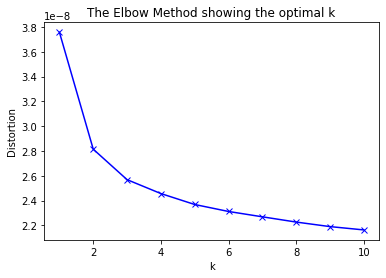

In [ ]:
# Find the best number of clusters using the elbow method
distortions = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(flat_images)
    distortions.append(kmeans.inertia_)
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# Apply K-Means clustering with the best number of clusters to the flattened compressed images
best_k = 9  # Change this to the number of clusters you want to use
kmeans = KMeans(n_clusters=best_k)
cluster_labels = kmeans.fit_predict(flat_images)

# Visualize the clusters separately to identify the patterns within each cluster
for cluster in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_images = images[cluster_indices]
    cluster_compressed = compressed_images[cluster_indices]

Visualization

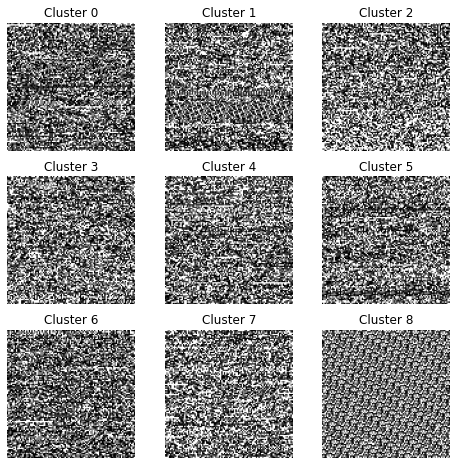

In [ ]:
import matplotlib.pyplot as plt

# Plot example images from each cluster
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    cluster_indices = np.where(cluster_labels == i)[0]
    example_index = cluster_indices[0]
    example_image = images[example_index]
    ax.imshow(example_image)
    ax.imshow(example_image, cmap='gray')
    ax.set_title(f"Cluster {i}")
    ax.axis('off')
plt.show()

## PCA

63/63 [==============================] - 8s 128ms/step


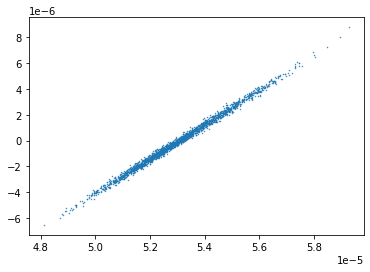

In [ ]:
# Extract the encoder from the autoencoder model
encoder = Model(input_img, encoded)

# Use the encoder to transform the images to the compact representation
encoded_imgs = encoder.predict(images)

# Apply PCA to reduce the dimensionality of the compact representation to 2 dimensions
pca = PCA(n_components=2)
pca_encoded_imgs = pca.fit_transform(encoded_imgs.reshape(len(encoded_imgs), -1))

# Plot the transformed images in the 2D space
plt.scatter(pca_encoded_imgs[:, 0], pca_encoded_imgs[:, 1], s=0.2)
plt.show()


## T-SNE

63/63 [==============================] - 8s 126ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


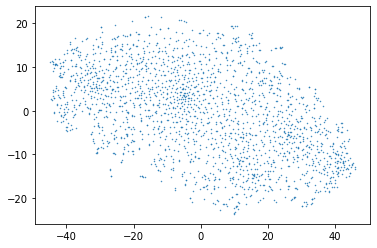

In [ ]:
from sklearn.manifold import TSNE

# Extract the encoder from the autoencoder model
encoder = Model(input_img, encoded)

# Use the encoder to transform the images to the compact representation
encoded_imgs = encoder.predict(images)

# Apply t-SNE to reduce the dimensionality of the compact representation to 2 dimensions
tsne = TSNE(n_components=2)
tsne_encoded_imgs = tsne.fit_transform(encoded_imgs.reshape(len(encoded_imgs), -1))

# Plot the transformed images in the 2D space
plt.scatter(tsne_encoded_imgs[:, 0], tsne_encoded_imgs[:, 1],s=0.2)
plt.show()


-53.761959075927734 54.851715087890625 -28.155078125 26.17571563720703


Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

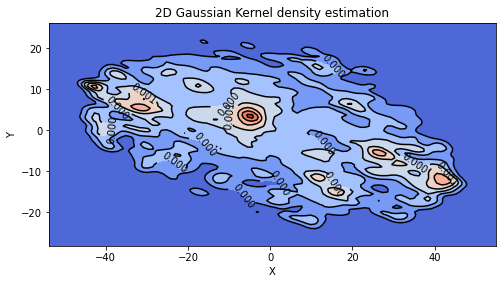

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Extract x and y
x = tsne_encoded_imgs[:, 0]
y = tsne_encoded_imgs[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values, bw_method=0.08)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

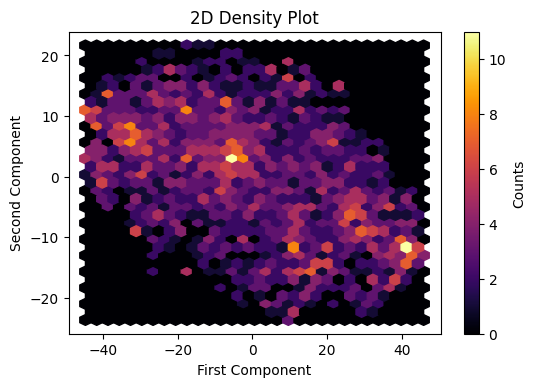

In [ ]:
# Plot the 2D density visualization
fig = plt.figure(dpi=100)
plt.hexbin(tsne_encoded_imgs[:, 0], tsne_encoded_imgs[:, 1], gridsize=30, cmap='inferno')
plt.title("2D Density Plot")
plt.xlabel("First Component")
plt.ylabel("Second Component")
cb = plt.colorbar()
cb.set_label("Counts")
# Set the size of the plot
plt.show()
